## Statistics of Tropical Cyclones (TCs) wind fields derived from Synthetic Aperture Radar (SAR) imagery
Dataset of 341 SAR files stored in .zarr format


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
import zarr
from scipy.interpolate import griddata
from datetime import datetime

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)

In [2]:
### TODO: Google Cloud data access and opening

### PATHS
dir_path = '/home/arthur/data/cyclobs/centered_rotated_files_06012022/clean_dataset/zarr_data/'
filename = 'tc_sar_data.zarr'

### OPEN FILES
ds_all = xr.open_zarr(dir_path + filename)

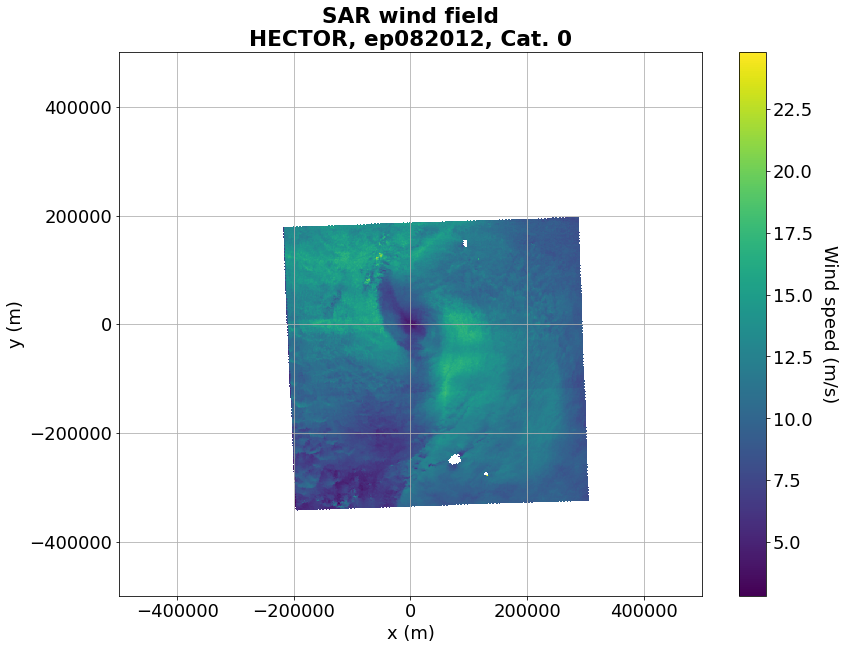

In [3]:
### PLOTTING WIND FIELDS
def plot_wind_field(ds_all, time_idx):
    # Open figure
    fig, _ = plt.subplots()
    
    # Title
    name = ds_all.isel(time=time_idx)['storm_name'].values
    tcId = ds_all.isel(time=time_idx)['storm_id'].values
    cat  = int(ds_all.isel(time=time_idx)['cat'])
    plt.title('SAR wind field\n%s, %s, Cat. %i'%(name, tcId, cat), weight='bold')
    
    # Plot
    x, y = np.meshgrid(ds_all.isel(time=time_idx)['x'], ds_all.isel(time=time_idx)['y']) # Defining 2D coordinates
    plt.pcolormesh(x, y, ds_all.isel(time=time_idx)['wind_speed'])                       # Plot the wind field
    plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid()                                 # Add axis legend
    plt.subplots_adjust(right=0.8)                                                       # Colorbar - line 1
    cbar = plt.colorbar()                                                                # Colorbar - line 2
    cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25     # Colorbar - line 3
    
plot_wind_field(ds_all, time_idx=0)

Indexes for HECTOR:  [  0  85  86  87 154 155 269 270]


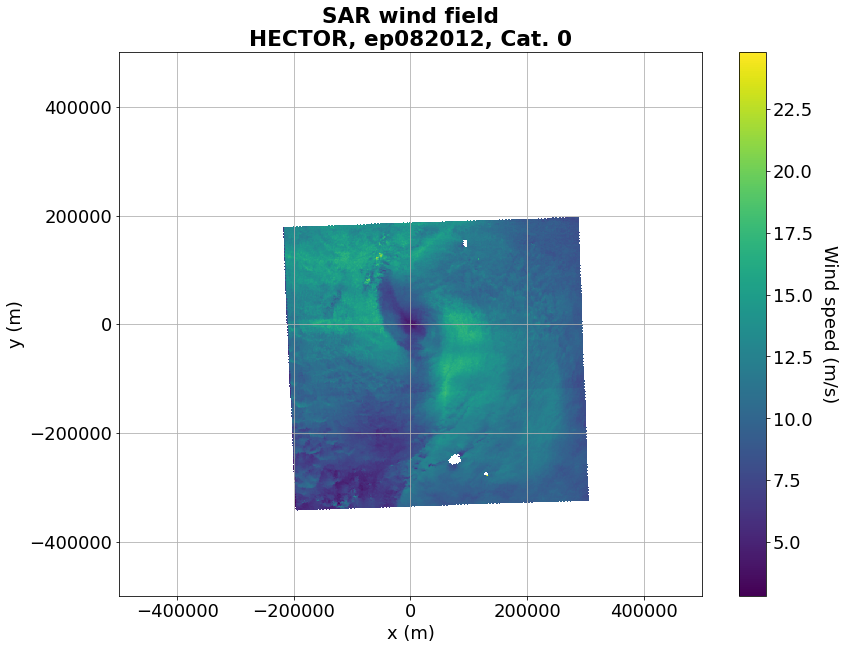

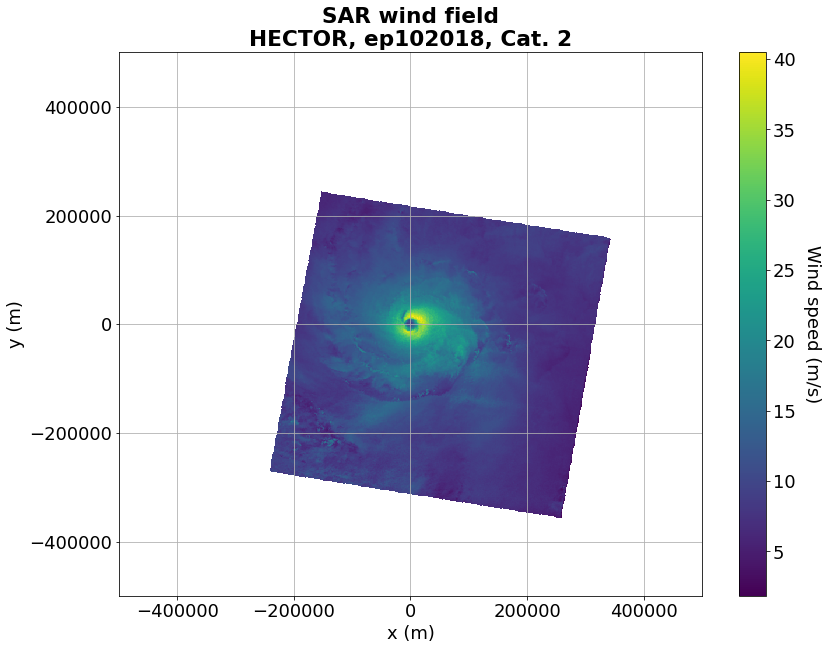

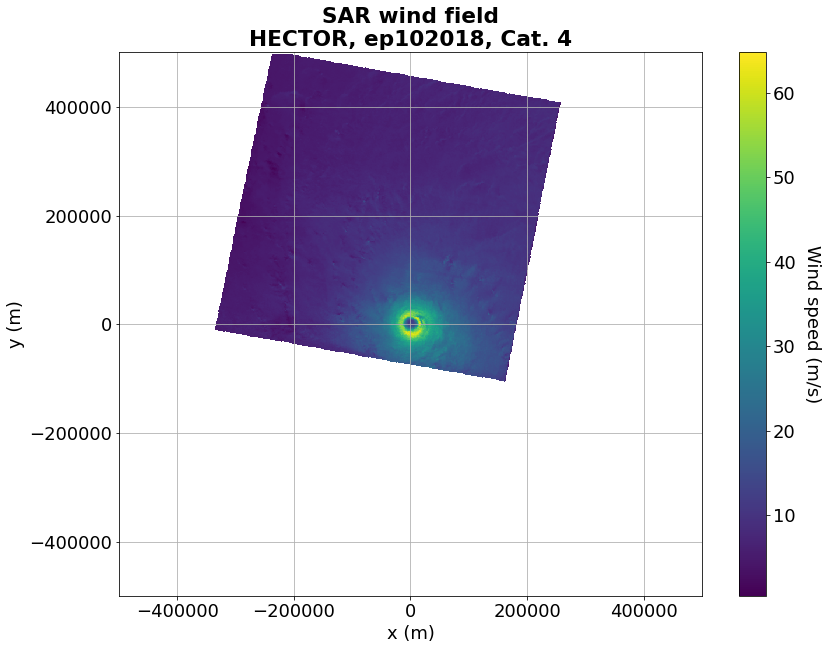

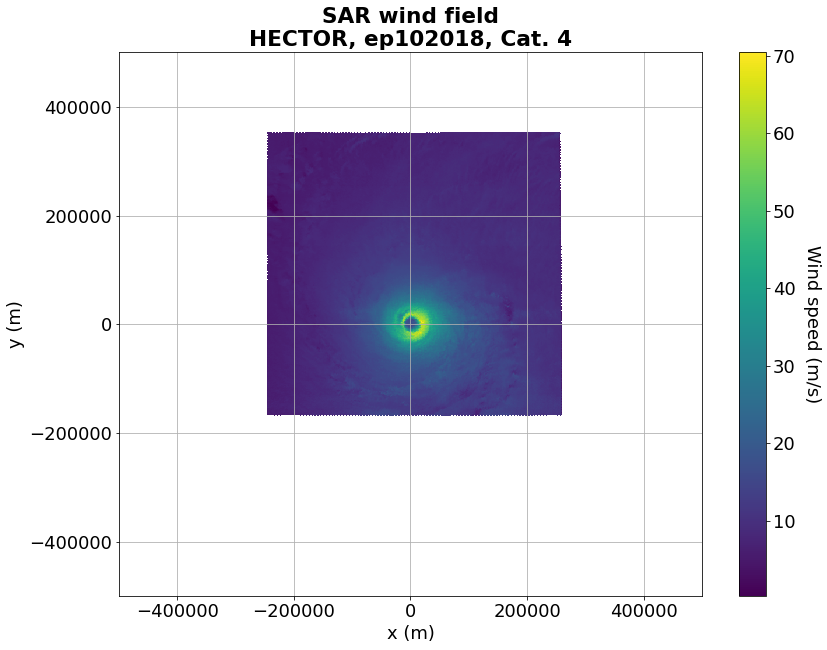

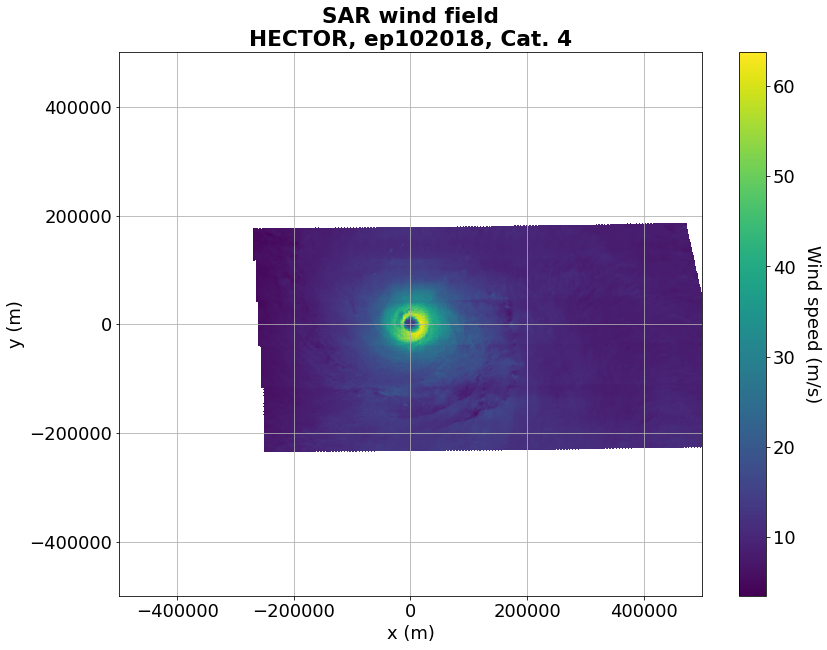

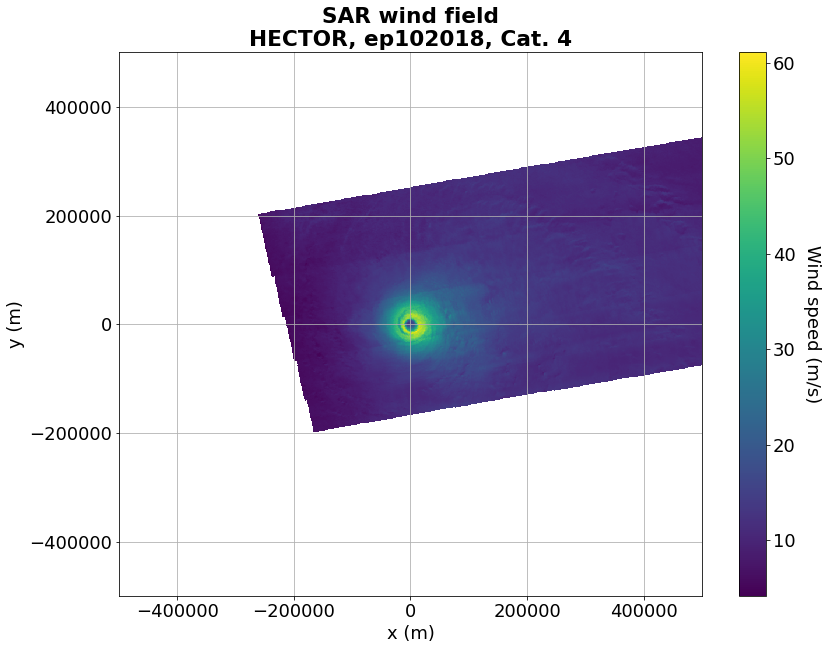

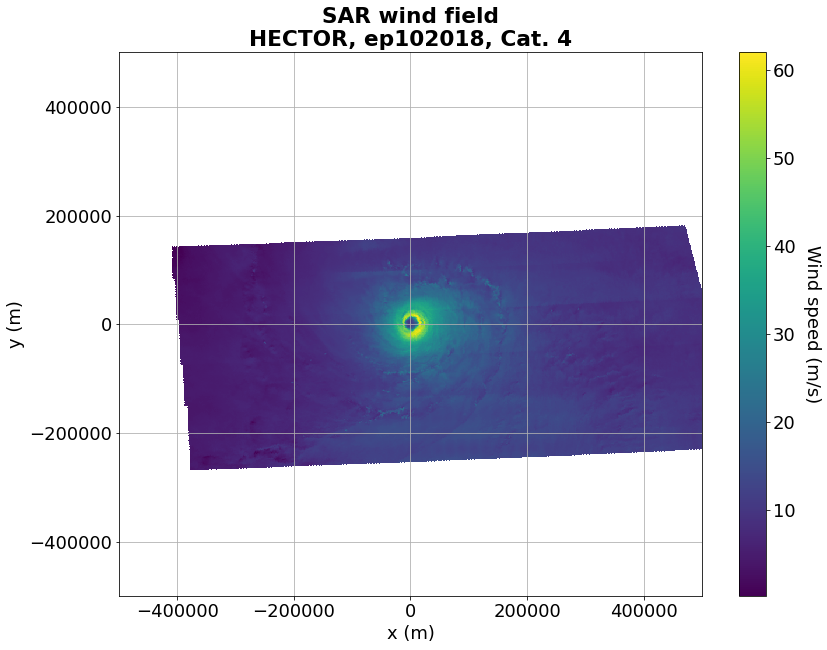

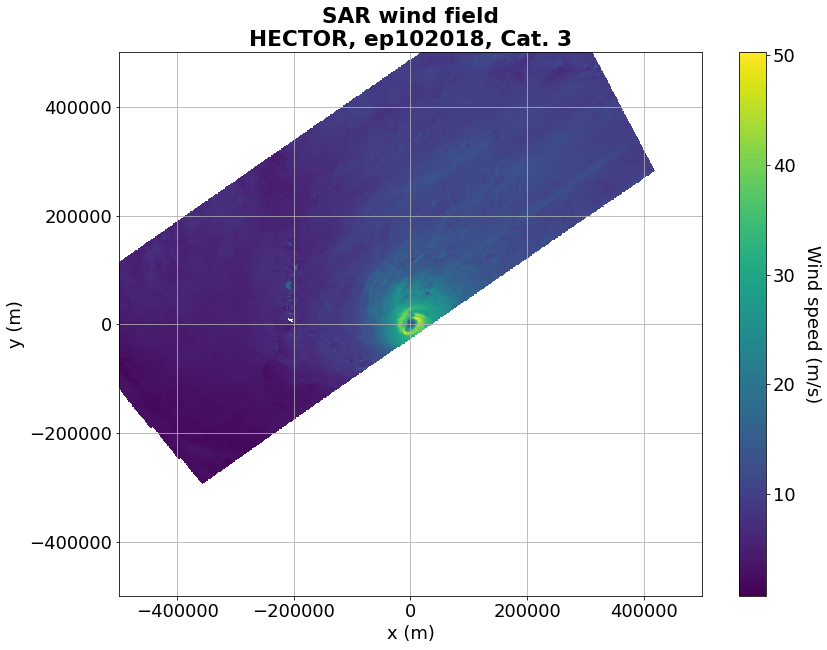

In [4]:
### FIND ALL TIME INDEXES FROM NAME AND PLOT ALL CORRESPONDING OBSERVATIONS
def find_time_idx(ds_all, storm_name):
    return np.where(ds_all['storm_name']==storm_name)[0]

storm_name = 'HECTOR'
print('Indexes for %s: '%storm_name, find_time_idx(ds_all, storm_name))
for time_idx in find_time_idx(ds_all, storm_name):
    plot_wind_field(ds_all, time_idx)

CPU times: user 8.66 s, sys: 1.53 s, total: 10.2 s
Wall time: 2.55 s


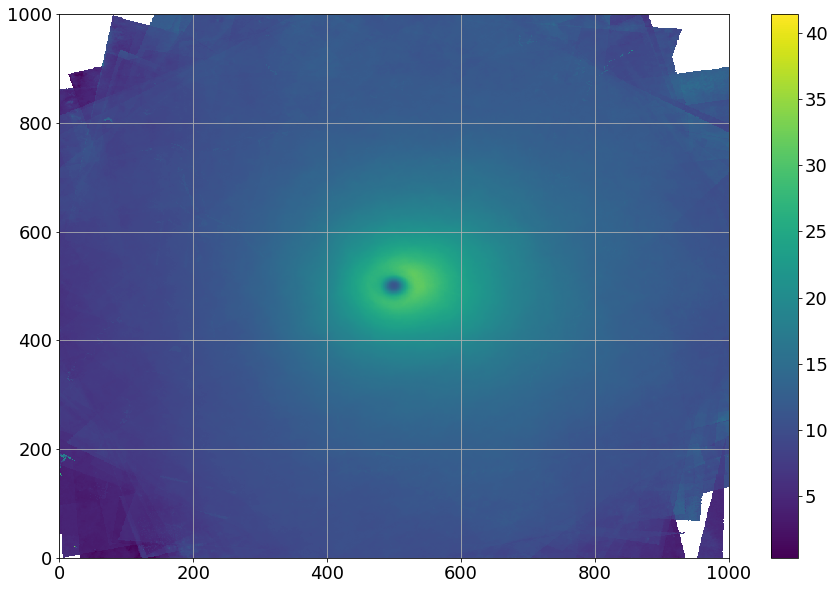

In [5]:
%%time
### DISPLAY AVERAGE WIND FIELD
mean_ws = np.nanmean(ds_all['wind_speed'], axis=0)
plt.pcolormesh(mean_ws);plt.grid();plt.colorbar()

Cat. 0 = 92
Cat. 1 = 82
Cat. 2 = 41
Cat. 3 = 55
Cat. 4 = 54
Cat. 5 = 17


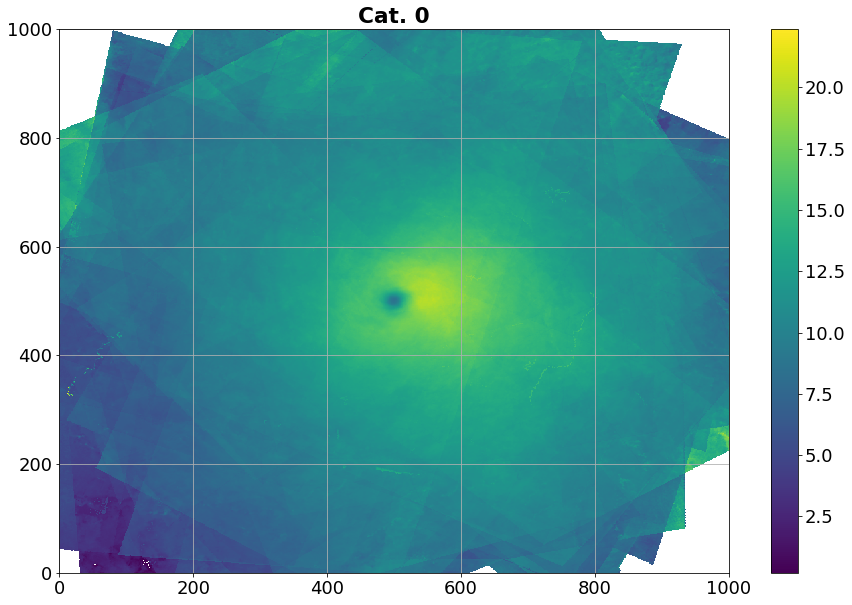

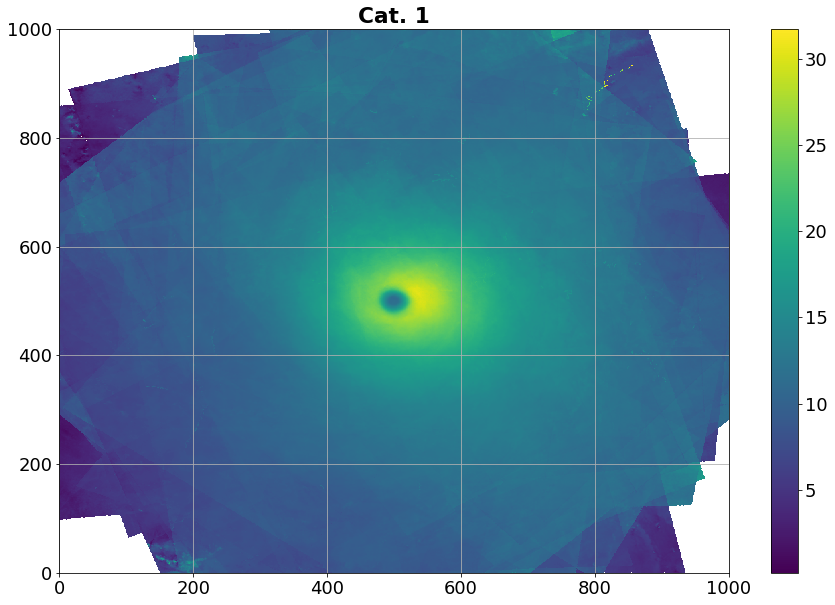

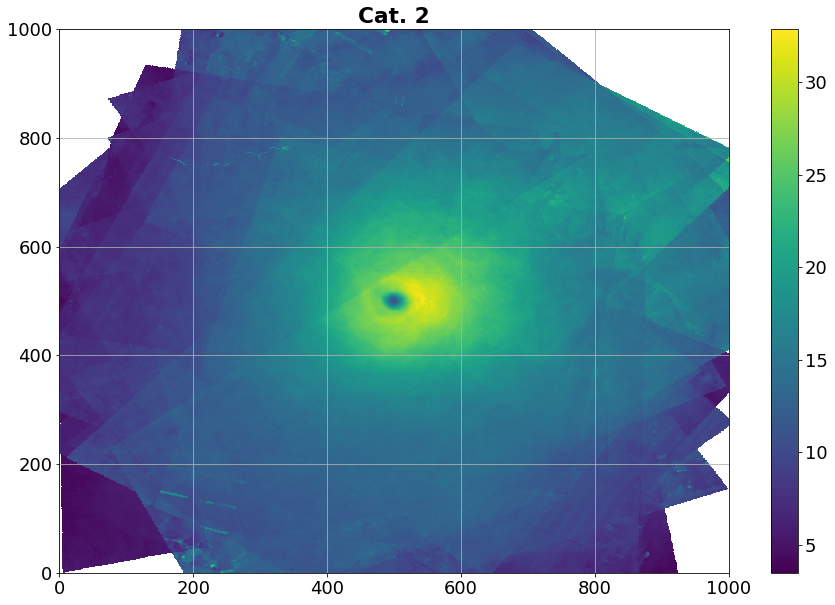

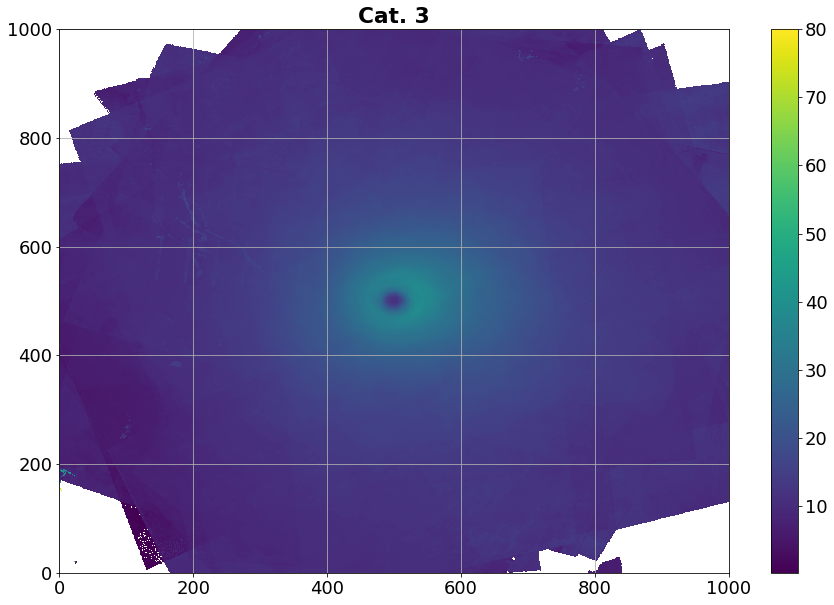

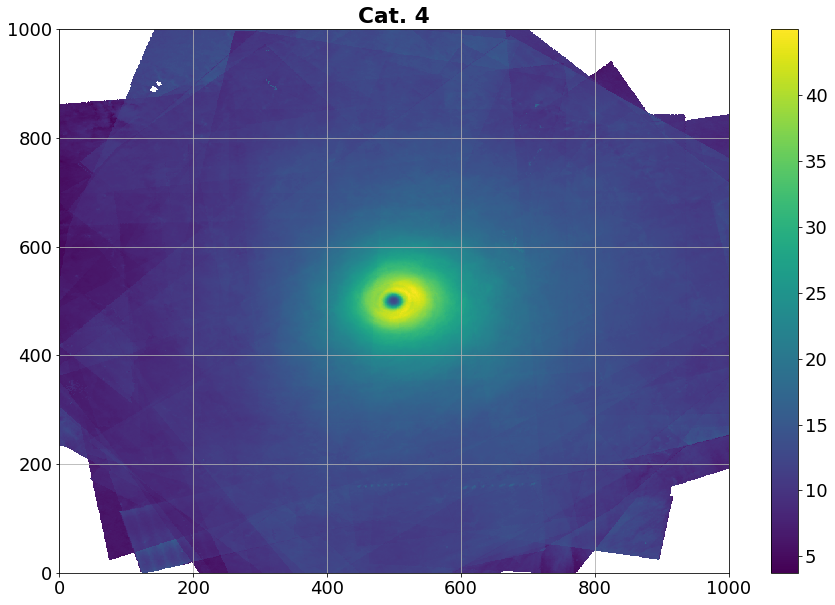

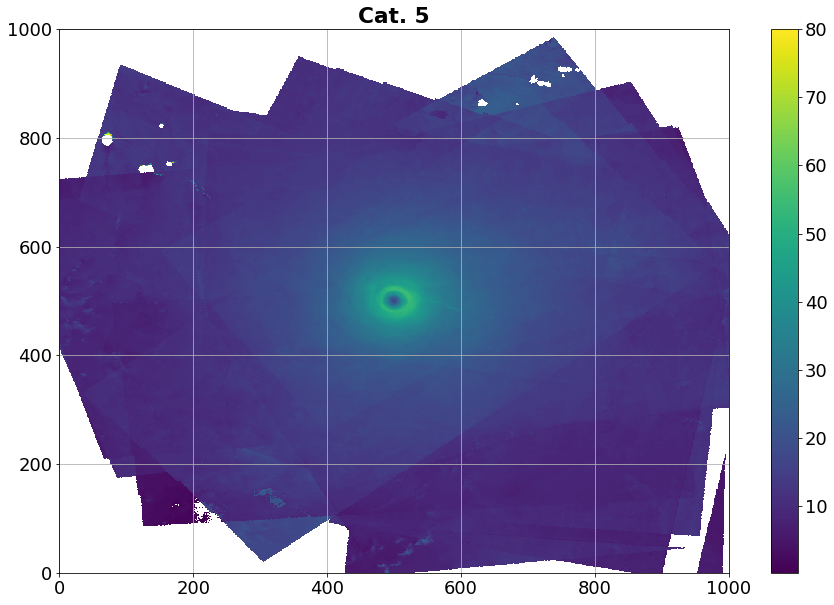

<Figure size 1080x720 with 0 Axes>

In [6]:
### DISPLAY MEAN BY CATEGORY
# Compute
mean_ws_by_cat = []
for cat, ds_cat in ds_all.groupby('cat'):
    print('Cat. %i ='%cat, ds_cat.dims['time'])
    mean_ws_by_cat.append(np.nanmean(ds_cat['wind_speed'], axis=0))

# Display
for cat, mean_ws in enumerate(mean_ws_by_cat):
    plt.title('Cat. %i'%cat, weight='bold')
    plt.pcolormesh(mean_ws);plt.grid();plt.colorbar()
    plt.show();plt.clf()

In [7]:
### COVARIANCE OF FIRST n FIELDS
n_total = len(ds_all['time'])
n       = 50 # nb of samlpes
dsn     = ds_all.isel(time=slice(0, n))

# Put on lower resolution grid
resolution = 25 # in pixels (here = km)
xHR, yHR   = np.meshgrid(dsn['x'], dsn['y'])
xLR, yLR   = np.meshgrid(dsn['x'][::resolution], dsn['y'][::resolution])

# Interpolate to lower resolution and concatenate
# Initialize
ds_wsHR    = np.array(dsn.isel(time=0)['wind_speed']) # convert to np.array
conc       = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
conc       = np.expand_dims(conc, axis=0)
# Loop
for i in tqdm(range(n - 1)):
    i         += 1
    ds_wsHR    = np.array(dsn.isel(time=i)['wind_speed']) # convert to np.array
    new        = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
    new        = np.expand_dims(new, axis=0)
    conc       = np.concatenate((conc, new), axis=0)   
print('Shape of concatenated array: ', conc.shape)

# Flatten
flat = np.reshape(conc, (conc.shape[0], conc.shape[1] * conc.shape[2]))
print('Shape of flattened array: ', flat.shape)

100%|███████████████████████████████████████████| 49/49 [00:09<00:00,  4.91it/s]

Shape of concatenated array:  (50, 40, 40)
Shape of flattened array:  (50, 1600)


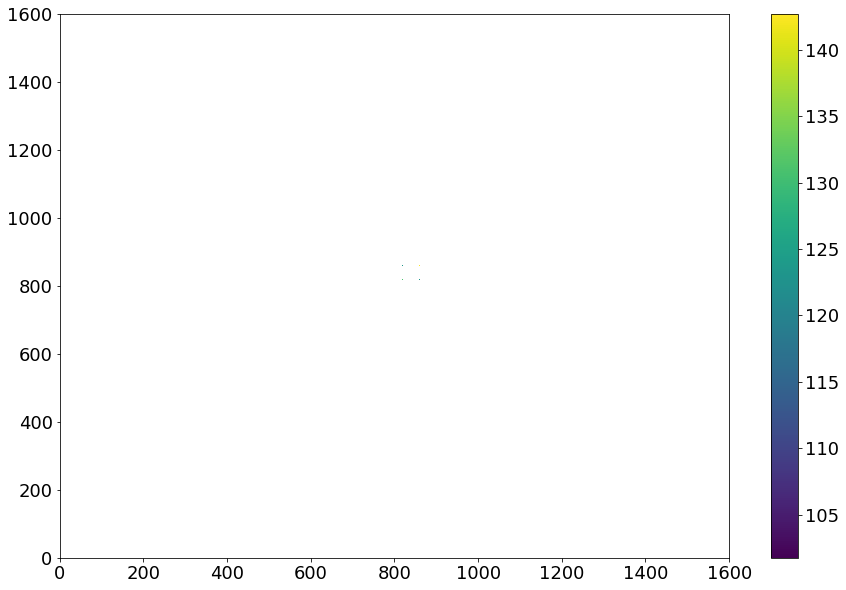

In [8]:
# Compute covariance USING DASK
# CAVEAT: how NaNs are handled? 
z       = da.array.cov(flat, rowvar=False)
cov_mat = z.compute()
plt.pcolormesh(cov_mat);plt.colorbar()

Shape of gap: (50, 1600)


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 10.92it/s]


Shape of product:  (50, 1600, 1600)
Shape of covariance matrix:  (1600, 1600)


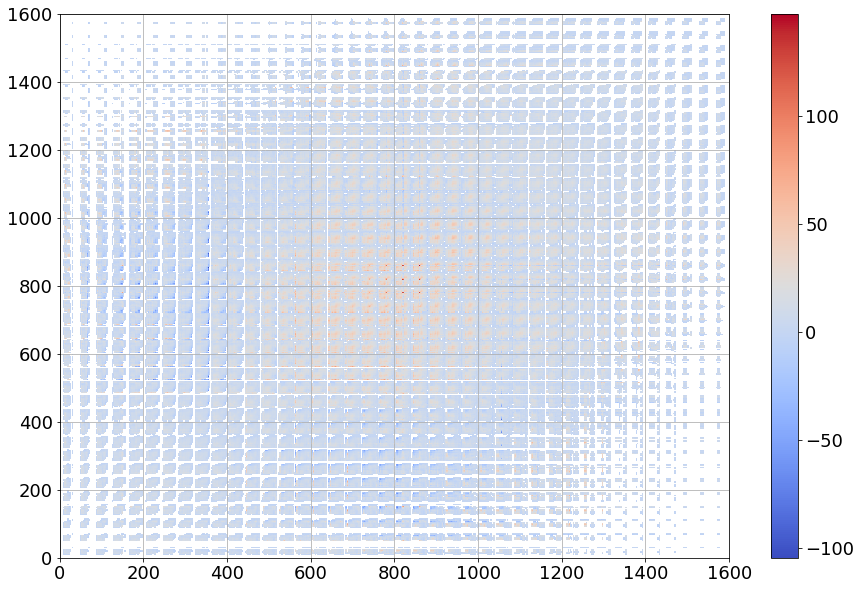

In [15]:
# Compute covariance handling NaNs
gap     = flat - np.nanmean(flat, axis=0) # 10 samples of x - E(x) transposed
print('Shape of gap:', gap.shape)

# Initialize
x_Ex    = np.expand_dims(gap[0, :], axis=1)
product = np.dot(x_Ex, np.transpose(x_Ex))
product = np.expand_dims(product, axis=0)
# Loop
for i in tqdm(range(n - 1)):
    x_Ex    = np.expand_dims(gap[i, :], axis=1)
    new     = np.dot(x_Ex, np.transpose(x_Ex))
    new     = np.expand_dims(new, axis=0)
    product = np.concatenate((product, new), axis=0)
print('Shape of product: ', product.shape)

# Compute average
# i.e E(product) where product = (x - E(x)).(x - E(x)).T
cov_mat = np.nanmean(product, axis=0)
print('Shape of covariance matrix: ', cov_mat.shape)

# Plot
cov_mat.shape
plt.pcolormesh(cov_mat, cmap='coolwarm');plt.colorbar();plt.grid()

(array([2.00000e+00, 4.00000e+00, 2.00000e+00, 2.00000e+00, 1.80000e+01,
        4.60000e+01, 6.20000e+01, 5.00000e+01, 8.60000e+01, 1.30000e+02,
        2.32000e+02, 2.90000e+02, 5.54000e+02, 7.16000e+02, 1.36000e+03,
        2.30200e+03, 3.63600e+03, 6.22800e+03, 1.13540e+04, 3.43420e+04,
        2.64528e+05, 3.55098e+05, 3.65173e+05, 2.37662e+05, 1.28807e+05,
        6.82520e+04, 3.77770e+04, 2.13020e+04, 1.09280e+04, 5.16000e+03,
        2.52400e+03, 1.11000e+03, 5.45000e+02, 3.15000e+02, 1.15000e+02,
        5.20000e+01, 2.60000e+01, 9.00000e+00, 1.40000e+01, 7.00000e+00,
        4.00000e+00, 1.20000e+01, 1.00000e+01, 4.00000e+00, 4.00000e+00,
        4.00000e+00, 5.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([-104.49398692,  -99.4611731 ,  -94.42835928,  -89.39554547,
         -84.36273165,  -79.32991783,  -74.29710401,  -69.2642902 ,
         -64.23147638,  -59.19866256,  -54.16584875,  -49.13303493,
         -44.10022111,  -39.06740729,  -34.03459348,  -29.001779

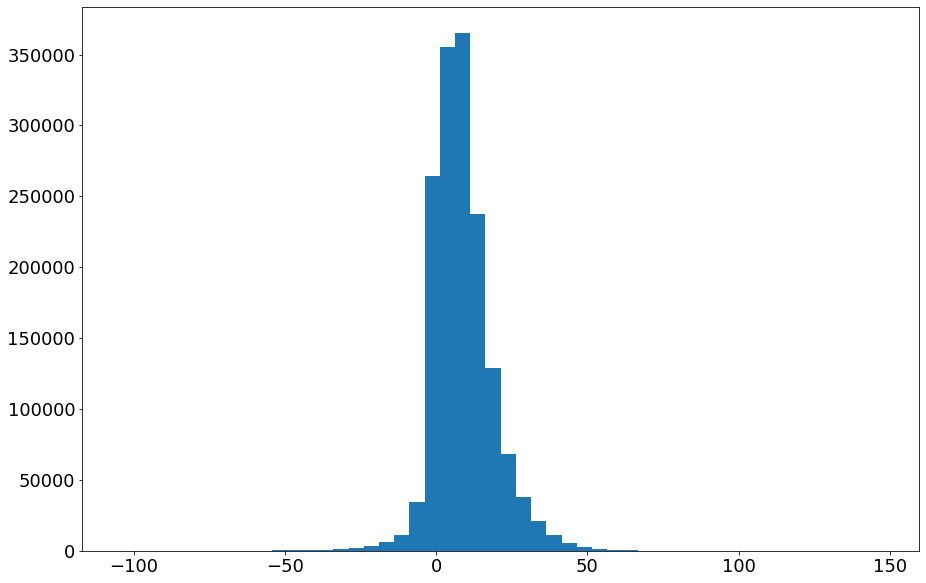

In [24]:
### Histogram of covariance matrix
plt.hist(cov_mat.flatten(), bins=50)

In [161]:
from scipy.signal import convolve2d

def cart2pol(x, y):
    r  = np.sqrt(x**2 + y**2)
    th = np.arctan2(y, x)
    return r, th

def compute_SAR_2D_Rmax_Vmax(ds):
    # Put zeros where NaNs and ones elsewhere
    ds_ws                    = np.asarray(ds['wind_speed'])
    ds_ones                  = np.ones(ds_ws.shape)
    ds_ones[np.isnan(ds_ws)] = 0.

    # Convolve this with a 10 x 10 kernel of ones to count the number of NaNs
    kernel                   = np.ones((10, 10))
    valid_counter            = convolve2d(ds_ones, kernel, mode='same')
    valid_counter           /= kernel.shape[0] * kernel.shape[1]

    # Set to NaN where threshold is exceeded
    thresh                        = 0.99
    ds_ws[valid_counter < thresh] = np.nan # if there is less than 99% (thresh = 0.99) of valid values, we set to nan 

    # Compute Rmax_SAR_2D and Vmax_SAR_2D
    idx_max                  = np.nanargmax(ds_ws)
    Vmax_SAR_2D              = np.reshape(np.asarray(ds_ws), -1)[idx_max]
    Rmax_SAR_2D              = np.reshape(np.asarray(ds['r']), -1)[idx_max]
    
    return Rmax_SAR_2D, Vmax_SAR_2D

# Concatenate samples only with Rmax < 150
n            = n_total
ds           = ds_all.isel(time=0)
r, th        = cart2pol(ds['x'], ds['y'])
ds           = ds.assign_coords({'r': r, 'th': th})
ds_wsHR      = np.array(ds['wind_speed'])             # convert to np.array
conc         = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
conc         = np.expand_dims(conc, axis=0)
Rmax_conc, _ = compute_SAR_2D_Rmax_Vmax(ds)
Rmax_conc    = np.expand_dims(Rmax_conc, axis=0)
for i in tqdm(range(n - 1)):
    i += 1
    ds    = ds_all.isel(time=i)
    
    # Assign polar coordinates to ds
    r, th = cart2pol(ds['x'], ds['y'])
    ds    = ds.assign_coords({'r': r, 'th': th})
    
    # LR
    ds_wsHR      = np.array(ds['wind_speed'])             # convert to np.array
    new          = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
    new          = np.expand_dims(new, axis=0)
    # plot_wind_field(ds_all, i)
    
    # Compute Rmax and concatenate
    Rmax_new, _ = compute_SAR_2D_Rmax_Vmax(ds)
    Rmax_new    = np.expand_dims(Rmax_new, axis=0)
    if round(Rmax / 1000) < 150:
        conc      = np.concatenate((conc, new), axis=0)
        Rmax_conc = np.concatenate((Rmax_conc, Rmax_new), axis=0)
    else:
        print('Sample n°%i not added: Rmax = '%i, round(Rmax / 1000))
        
Rmax_conc /= 1000. # convert to km

100%|█████████████████████████████████████████| 340/340 [02:17<00:00,  2.47it/s]


Shape of flattened array:  (341, 1600)
Shape of gap: (50, 1600)


100%|██████████████████████████████████████| 340/340 [00:00<00:00, 11790.62it/s]

Shape of product:  (341, 1600)
Shape of covariance matrix:  (1600,)


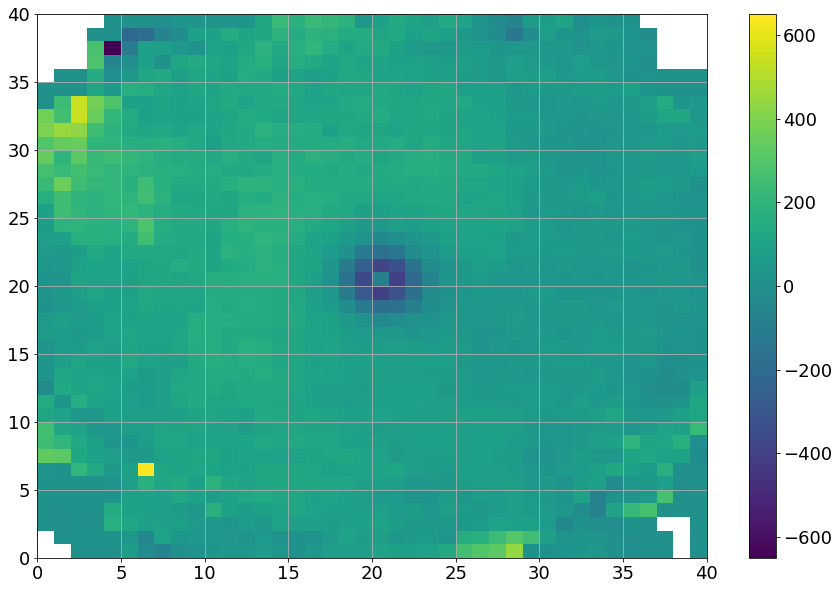

In [162]:
### Compute covariance matrix of TCs with Rmax
# Flatten
flat = np.reshape(conc, (conc.shape[0], conc.shape[1] * conc.shape[2]))
print('Shape of flattened array: ', flat.shape)

# Compute covariance handling NaNs
gap_ws   = flat - np.nanmean(flat, axis=0)   # 10 samples of x - E(x) transposed
gap_rmax = Rmax_conc - np.nanmean(Rmax_conc) # same for Rmax
print('Shape of gap:', gap.shape)

# Initialize
product = gap_ws[0, :] * gap_rmax[0]
product = np.expand_dims(product, axis=0)
# Loop
for i in tqdm(range(n - 1)):
    i      += 1
    new     = gap_ws[i, :] * gap_rmax[i]
    new     = np.expand_dims(new, axis=0)
    product = np.concatenate((product, new), axis=0)
print('Shape of product: ', product.shape)

# Compute average
# i.e E(product) where product = (x - E(x)).(x - E(x)).T
cov_mat = np.nanmean(product, axis=0)
print('Shape of covariance matrix: ', cov_mat.shape)

# Plot
cov_mat = np.reshape(cov_mat, (40, 40))
plt.pcolormesh(cov_mat);plt.colorbar();plt.grid()

#### Covariance between TC and Vmax_2D

In [191]:
from scipy.signal import convolve2d

def cart2pol(x, y):
    r  = np.sqrt(x**2 + y**2)
    th = np.arctan2(y, x)
    return r, th

def compute_SAR_2D_Rmax_Vmax(ds):
    # Put zeros where NaNs and ones elsewhere
    ds_ws                    = np.asarray(ds['wind_speed'])
    ds_ones                  = np.ones(ds_ws.shape)
    ds_ones[np.isnan(ds_ws)] = 0.

    # Convolve this with a 10 x 10 kernel of ones to count the number of NaNs
    kernel                   = np.ones((10, 10))
    valid_counter            = convolve2d(ds_ones, kernel, mode='same')
    valid_counter           /= kernel.shape[0] * kernel.shape[1]

    # Set to NaN where threshold is exceeded
    thresh                        = 0.99
    ds_ws[valid_counter < thresh] = np.nan # if there is less than 99% (thresh = 0.99) of valid values, we set to nan 

    # Compute Rmax_SAR_2D and Vmax_SAR_2D
    idx_max                  = np.nanargmax(ds_ws)
    Vmax_SAR_2D              = np.reshape(np.asarray(ds_ws), -1)[idx_max]
    Rmax_SAR_2D              = np.reshape(np.asarray(ds['r']), -1)[idx_max]
    
    return Rmax_SAR_2D, Vmax_SAR_2D

# Concatenate samples only with Rmax < 150
n            = n_total
ds           = ds_all.isel(time=0)
r, th        = cart2pol(ds['x'], ds['y'])
ds           = ds.assign_coords({'r': r, 'th': th})
conc         = np.array(ds['wind_speed'])             # convert to np.array
conc         = np.expand_dims(conc, axis=0)
_, Vmax_conc = compute_SAR_2D_Rmax_Vmax(ds)
Vmax_conc    = np.expand_dims(Vmax_conc, axis=0)
for i in tqdm(range(n - 1)):
    i += 1
    ds    = ds_all.isel(time=i)
    
    # Assign polar coordinates to ds
    r, th = cart2pol(ds['x'], ds['y'])
    ds    = ds.assign_coords({'r': r, 'th': th})
    
    new          = np.array(ds['wind_speed'])             # convert to np.array
    new          = np.expand_dims(new, axis=0)
    
    # Compute Rmax/Vmax and concatenate
    Rmax_new, Vmax_new = compute_SAR_2D_Rmax_Vmax(ds)
    Vmax_new           = np.expand_dims(Vmax_new, axis=0)
    if round(Rmax_new / 1000) < 150:
        conc      = np.concatenate((conc, new), axis=0)
        Vmax_conc = np.concatenate((Vmax_conc, Vmax_new), axis=0)
    else:
        print('Sample n°%i not added: Rmax = '%i, round(Rmax_new / 1000))

  6%|██▎                                       | 19/340 [00:04<01:11,  4.48it/s]

Sample n°19 not added: Rmax =  447


  9%|███▉                                      | 32/340 [00:07<01:19,  3.89it/s]

Sample n°32 not added: Rmax =  172


 18%|███████▌                                  | 61/340 [00:15<01:16,  3.63it/s]

Sample n°61 not added: Rmax =  201


 19%|███████▉                                  | 64/340 [00:16<01:14,  3.71it/s]

Sample n°64 not added: Rmax =  233


 21%|████████▋                                 | 70/340 [00:17<01:13,  3.65it/s]

Sample n°70 not added: Rmax =  231


 24%|██████████                                | 81/340 [00:21<01:12,  3.56it/s]

Sample n°81 not added: Rmax =  256


 29%|███████████▉                              | 97/340 [00:26<01:10,  3.46it/s]

Sample n°97 not added: Rmax =  294


 31%|████████████▊                            | 106/340 [00:28<01:08,  3.42it/s]

Sample n°106 not added: Rmax =  409


 34%|█████████████▊                           | 115/340 [00:31<01:07,  3.34it/s]

Sample n°115 not added: Rmax =  335


 39%|███████████████▉                         | 132/340 [00:37<01:04,  3.21it/s]

Sample n°132 not added: Rmax =  178


 45%|██████████████████▍                      | 153/340 [00:45<01:00,  3.07it/s]

Sample n°153 not added: Rmax =  496


 49%|████████████████████▎                    | 168/340 [00:50<00:58,  2.96it/s]

Sample n°168 not added: Rmax =  337


 50%|████████████████████▍                    | 169/340 [00:50<00:51,  3.31it/s]

Sample n°169 not added: Rmax =  494


 51%|████████████████████▉                    | 174/340 [00:52<00:53,  3.07it/s]

Sample n°174 not added: Rmax =  170


 54%|██████████████████████▏                  | 184/340 [00:56<00:54,  2.89it/s]

Sample n°184 not added: Rmax =  306


 55%|██████████████████████▌                  | 187/340 [00:57<00:50,  3.04it/s]

Sample n°187 not added: Rmax =  172


 56%|███████████████████████▏                 | 192/340 [00:59<00:50,  2.95it/s]

Sample n°192 not added: Rmax =  196


 61%|█████████████████████████▏               | 209/340 [01:06<00:47,  2.74it/s]

Sample n°209 not added: Rmax =  365


 64%|██████████████████████████▍              | 219/340 [01:10<00:44,  2.72it/s]

Sample n°219 not added: Rmax =  157


 65%|██████████████████████████▊              | 222/340 [01:11<00:41,  2.87it/s]

Sample n°222 not added: Rmax =  184


 69%|████████████████████████████▍            | 236/340 [01:17<00:39,  2.64it/s]

Sample n°236 not added: Rmax =  233


 72%|█████████████████████████████▍           | 244/340 [01:21<00:37,  2.58it/s]

Sample n°244 not added: Rmax =  181


 73%|██████████████████████████████           | 249/340 [01:23<00:34,  2.62it/s]

Sample n°249 not added: Rmax =  245


 75%|██████████████████████████████▊          | 256/340 [01:26<00:32,  2.57it/s]

Sample n°256 not added: Rmax =  159


 79%|████████████████████████████████▏        | 267/340 [01:31<00:30,  2.39it/s]

Sample n°267 not added: Rmax =  181


 83%|██████████████████████████████████▏      | 283/340 [01:39<00:24,  2.30it/s]

Sample n°283 not added: Rmax =  208


 84%|██████████████████████████████████▍      | 286/340 [01:40<00:22,  2.45it/s]

Sample n°286 not added: Rmax =  316


 85%|██████████████████████████████████▋      | 288/340 [01:41<00:19,  2.64it/s]

Sample n°288 not added: Rmax =  173


 86%|███████████████████████████████████▍     | 294/340 [01:44<00:19,  2.35it/s]

Sample n°294 not added: Rmax =  229


 90%|████████████████████████████████████▊    | 305/340 [01:50<00:15,  2.23it/s]

Sample n°305 not added: Rmax =  337


 95%|██████████████████████████████████████▉  | 323/340 [01:59<00:07,  2.17it/s]

Sample n°323 not added: Rmax =  153


 99%|████████████████████████████████████████▍| 335/340 [02:06<00:02,  2.16it/s]

Sample n°335 not added: Rmax =  188


100%|█████████████████████████████████████████| 340/340 [02:09<00:00,  2.63it/s]


Shape of flattened array:  (309, 1000000)
Shape of gap: (50, 1600)


100%|█████████████████████████████████████████| 308/308 [00:51<00:00,  5.94it/s]


Shape of product:  (309, 1000000)
Shape of covariance matrix:  (1000000,)


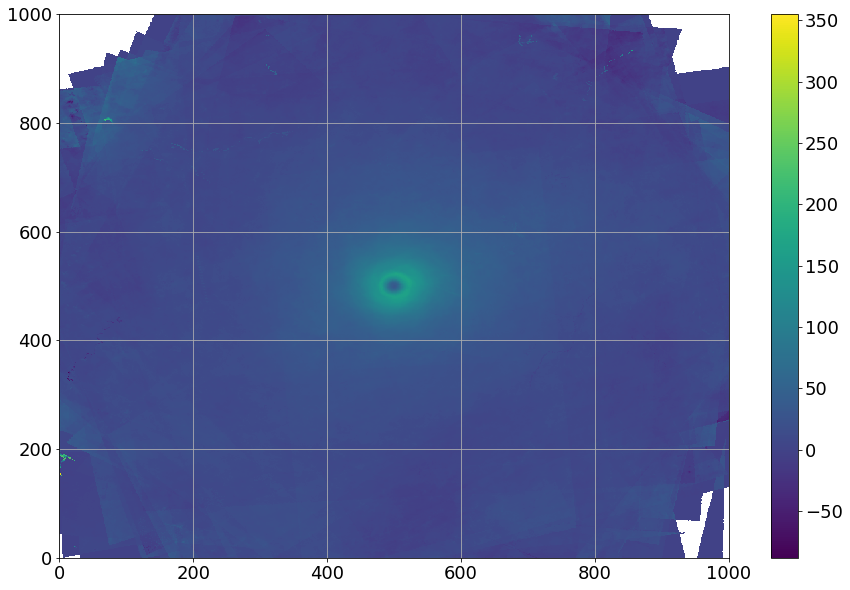

In [192]:
### Compute covariance matrix of TCs with Vmax_2D
# Flatten
flat = np.reshape(conc, (conc.shape[0], conc.shape[1] * conc.shape[2]))
print('Shape of flattened array: ', flat.shape)

# Compute covariance handling NaNs
gap_ws   = flat - np.nanmean(flat, axis=0)   # 10 samples of x - E(x) transposed
gap_vmax = Vmax_conc - np.nanmean(Vmax_conc) # same for Vmax

# Initialize
product = gap_ws[0, :] * gap_vmax[0]
product = np.expand_dims(product, axis=0)
# Loop
for i in tqdm(range(len(gap_vmax) - 1)):
    i      += 1
    new     = gap_ws[i, :] * gap_vmax[i]
    new     = np.expand_dims(new, axis=0)
    product = np.concatenate((product, new), axis=0)
print('Shape of product: ', product.shape)

# Compute average
# i.e E(product) where product = (x - E(x)).(x - E(x)).T
cov_mat = np.nanmean(product, axis=0)
print('Shape of covariance matrix: ', cov_mat.shape)

# Plot
cov_mat = np.reshape(cov_mat, (1000, 1000))
plt.pcolormesh(cov_mat);plt.colorbar();plt.grid()

In [11]:
### DISPLAY ALL SOUTHERN HEMISPHERE TCs
# ds2 = ds_all.where(ds_all['lat'][:, 499, 499] < 0)
# ds2['wind_speed'][:, :, :].values
# for time_idx in range(len(ds2.time)):
#     if ds_all['lat'][time_idx, 499, 499] < 0:
#         print(time_idx)
#         plot_wind_field(ds_all, time_idx=time_idx)

In [12]:
### TODO: Interpolate on regular (r, th) grid (OPTIONAL)
### Shift SH TCs ==> Already done
### REMOVE outlier pixels 
### Questions: how many cat.0, cat.1 etc.. do we have? In which basins? Wind field max? Wind speed mean? Average wind field etc...? Average wind field per category? 1D profile? 
### Covariance matrix? 1D covariance? 

In [13]:
import gcsfs

In [14]:
fs = gcsfs.GCSFileSystem(project='alert-ground-261008', token='anon', access='read_only')
fs.ls('project10_tc_sar')

_request non-retriable exception: Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket., 401
Traceback (most recent call last):
  File "/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/gcsfs/retry.py", line 115, in retry_request
    return await func(*args, **kwargs)
  File "/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/gcsfs/core.py", line 378, in _request
    validate_response(status, contents, path, args)
  File "/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/gcsfs/retry.py", line 102, in validate_response
    raise HttpError(error)
gcsfs.retry.HttpError: Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket., 401


HttpError: Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket., 401

In [ ]:
fs     = gcsfs.GCSFileSystem(token='anon', access='read_only')
mapper = fs.get_mapper('project10_tc_sar/tc_sar_data.zarr')
ds     = xr.open_zarr(mapper, consolidated=True)

In [ ]:
fs = gcsfs.GCSFileSystem(project='ds2class', token='anon', access='read_only')
fs.ls('project10_tc_sar')